In [1]:
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Loading the JSON file
with open('greyhack_reviews.json') as f:
    data = json.load(f)

# Extracting reviews data
reviews_data = data['reviews']

In [2]:
# Flattening the nested data
flattened_data = []

for review_id, review in reviews_data.items():
    # Flattening the top-level attributes
    flattened_review = review.copy()

    # Extracting and adding author details to the flattened_review
    author_data = review['author']
    for key, value in author_data.items():
        flattened_review['author_' + key] = value

    # Add the flattened review to the list
    flattened_data.append(flattened_review)

# Converting the flattened data to a DataFrame
reviews_df = pd.DataFrame(flattened_data)
reviews_df.info()

# Setting to display all columns
pd.set_option('display.max_columns', 999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   recommendationid                731 non-null    object 
 1   author                          731 non-null    object 
 2   language                        731 non-null    object 
 3   review                          731 non-null    object 
 4   timestamp_created               731 non-null    int64  
 5   timestamp_updated               731 non-null    int64  
 6   voted_up                        731 non-null    bool   
 7   votes_up                        731 non-null    int64  
 8   votes_funny                     731 non-null    int64  
 9   weighted_vote_score             731 non-null    object 
 10  comment_count                   731 non-null    int64  
 11  steam_purchase                  731 non-null    bool   
 12  received_for_free               731 

In [3]:
reviews_df.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,timestamp_dev_responded,developer_response
0,154402757,"{'steamid': '76561197967650790', 'num_games_ow...",english,This game is very realistic and is super fun! ...,1703541254,1703541254,True,1,0,0,0,True,False,True,True,,76561197967650790,177,84,514,514,167,1703564483,NaN,NaN
1,154400205,"{'steamid': '76561198207537119', 'num_games_ow...",english,I've been having too much fun playing it. Keep...,1703538947,1703538947,True,1,0,0,0,True,False,True,True,,76561198207537119,94,5,154,154,154,1703538758,NaN,NaN
2,154394209,"{'steamid': '76561198244171152', 'num_games_ow...",english,"Потрясающий симулятор!\nЯ не знаю, и не мог пр...",1703533594,1703533594,True,1,0,0,0,True,False,True,True,,76561198244171152,0,1,11003,237,10983,1703536530,NaN,NaN
3,154389145,"{'steamid': '76561198043718864', 'num_games_ow...",english,"A good, and I mean good, hacking simulator for...",1703529134,1703529134,True,3,0,0.54356849193572998,0,True,False,True,True,,76561198043718864,200,11,21,21,17,1703529507,NaN,NaN
4,154388760,"{'steamid': '76561198030883946', 'num_games_ow...",english,This is an amazingly realistic hacking simulat...,1703528804,1703528804,True,3,0,0.54356849193572998,0,True,False,True,True,,76561198030883946,0,21,46,46,35,1703529325,NaN,NaN


In [4]:
# Dropping unnecessary columns
reviews_df.drop(columns=['recommendationid', 'author', 'hidden_in_steam_china', 'steam_china_location', 'author_steamid', 'timestamp_dev_responded', 'developer_response'], inplace=True )

In [5]:
# Convert timestamps to date and time
reviews_df['timestamp_created'] = pd.to_datetime(reviews_df['timestamp_created'], unit='s') # time review created
reviews_df['timestamp_updated'] = pd.to_datetime(reviews_df['timestamp_updated'], unit='s') # time review updated
reviews_df['author_last_played'] = pd.to_datetime(reviews_df['author_last_played'], unit='s') #last time user played (can be updated by running review_scrape.ipynb)

In [6]:
# Finding data points with sentiment values 
# Some rows have 'english' in language col although they belong to other language in reviews col
reviews_df['textblob_sentiment'] = reviews_df['review'].apply(lambda x: TextBlob(x).sentiment.polarity) #simple sentiment analysis

# Showing that several reviews are in 'english' language although they belong to other language in language column
# Vice versa some rows have review sentiment_scores although the reviews are in languages other than English
# Languages to test: brazilian, french, german, russian, italian, polish, spanish, turkish, ukrainian    
language_test = 'german' # Looking for exceptions
reviews_df.loc[(reviews_df['language'] == language_test ) & (reviews_df['textblob_sentiment'] > 0)]

,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment
714,german,"The game is really cool, it's like a real comp...",2023-07-28 10:49:11,2023-07-28 10:49:11,True,0,0,0,0,True,False,True,0,2,1375,0,857,2023-10-11 17:34:07,0.100000
719,german,It's a nice game. If you haven't got a basic u...,2023-07-08 14:24:49,2023-07-08 14:24:49,True,0,0,0,0,True,False,True,0,6,750,0,750,2023-07-08 14:24:09,0.066667
725,german,nice,2023-05-29 17:37:02,2023-05-29 17:37:02,True,0,0,0,0,True,False,True,177,27,547,0,149,2023-06-01 12:43:52,0.600000


Among the list of languages supported, the above list has reviews that have values in sentiment analysis. After testing each language, some reviews are in English but others are not. The misleading values include french, polish and spanish.

In [8]:
# Removing rows that do not have sentiment analysis value (Assuming these are none English)
reviews_df = reviews_df[reviews_df.textblob_sentiment != 0] 

# Removing rows that have sentiment analysis value but language of review is in other language
reviews_df = reviews_df[~reviews_df['language'].isin(['french', 'polish', 'spanish'])] 

Skewness of the forever: 10.882496588784937
Skewness of the at_review: 7.794072142161134
Skewness of the two_weeks: 18.748595033080385


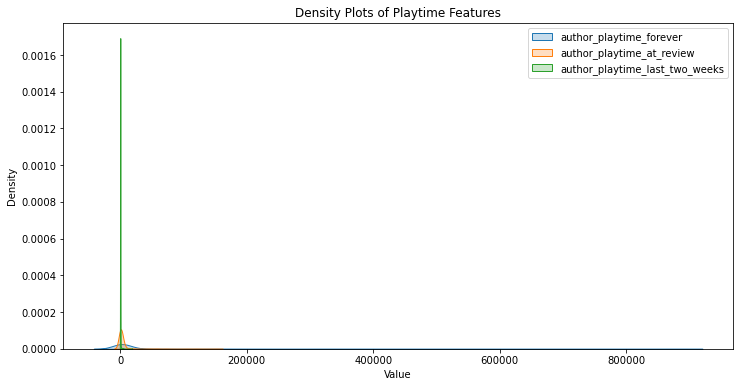

In [10]:
# Checking skewness of playtime features
forever_skewness = reviews_df['author_playtime_forever'].skew()
at_review_skewness = reviews_df['author_playtime_at_review'].skew()
two_weeks_skewness = reviews_df['author_playtime_last_two_weeks'].skew()

print(f"Skewness of the forever: {forever_skewness}")
print(f"Skewness of the at_review: {at_review_skewness}")
print(f"Skewness of the two_weeks: {two_weeks_skewness}")

col1 = 'author_playtime_forever'
col2 = 'author_playtime_at_review'
col3 = 'author_playtime_last_two_weeks'

plt.figure(figsize=(12, 6)) 

# Density Plot for each column
sns.kdeplot(reviews_df[col1], label=col1, fill=True)
sns.kdeplot(reviews_df[col2], label=col2, fill=True)
sns.kdeplot(reviews_df[col3], label=col3, fill=True)

# Adding labels and title
plt.title('Density Plots of Playtime Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [11]:
# Log transformation of playtime features due to right-skewness
reviews_df['log_playtime_forever'] = np.log1p(reviews_df['author_playtime_forever'])
reviews_df['log_playtime_at_review'] = np.log1p(reviews_df['author_playtime_at_review'])
reviews_df['log_playtime_last_two_weeks'] = np.log1p(reviews_df['author_playtime_last_two_weeks'])

# Standardizing playtime features with Z-score standardization for better model performance
scaler = StandardScaler()
reviews_df['normalized_playtime_forever'] = scaler.fit_transform(reviews_df[['log_playtime_forever']]) 
reviews_df['normalized_playtime_at_review'] = scaler.fit_transform(reviews_df[['log_playtime_at_review']])
reviews_df['normalized_playtime_last_two_weeks'] = scaler.fit_transform(reviews_df[['log_playtime_last_two_weeks']])

# Creating user engagement features
reviews_df['playtime_ratio'] = reviews_df['author_playtime_at_review'] / reviews_df['author_playtime_forever']
reviews_df['days_from_last_played_time'] = (pd.Timestamp('now') - reviews_df['author_last_played']).dt.days

# Creating reviews features
reviews_df['review_length'] = reviews_df['review'].apply(len)
reviews_df['review_word_count'] = reviews_df['review'].apply(lambda x: len(x.split()))

# Creating community interaction features
reviews_df['engagement_score'] = (reviews_df['votes_up'] + reviews_df['votes_funny'] + reviews_df['comment_count'])

# Categorical feature encoding
reviews_df['voted_up'] = reviews_df['voted_up'].astype(int)
reviews_df['steam_purchase'] = reviews_df['steam_purchase'].astype(int)
reviews_df['received_for_free'] = reviews_df['received_for_free'].astype(int)
reviews_df['playtime_category'] = pd.cut(reviews_df['author_playtime_forever'], bins=[0,100,500,1000,1000000], labels=["Low", "Medium", "High", "Very High"]) # Binning lifetime playing hours of the game to playtime categories
reviews_df['reviewer_experience'] = pd.cut(reviews_df['author_num_reviews'], bins=[0,5,20,1000], labels=["Newbie", "Experienced", "Veteran"])                 # Binning num of reviews by user to across Steam to review experience categories

In [12]:
# Using VADER sentiment analysis on 'reviews' column
nltk.downloader.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Returning sentiment score of input text
def get_vader_sentiment(text):
    return sia.polarity_scores(text)['compound']

reviews_df['vader_sentiment'] = reviews_df['review'].apply(get_vader_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/michaelknight/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
# Downloading stopwords
nltk.download('stopwords')

# Cleaning the review text from special characters for baseline models
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Removing special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    return tokens

reviews_df['cleaned_review_tokens'] = reviews_df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelknight/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Setting stopwords to English
stop_words = set(stopwords.words('english'))

# Defining custom list of stopwords (adjustable)
custom_stopwords = ['game']  # Removing 'game' due to the nature of data

# Adding custom stopwords to the existing set
stop_words.update(custom_stopwords)

# Removing stopwords from reviews for baseline models
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

reviews_df['review_tokens_no_stopwords'] = reviews_df['cleaned_review_tokens'].apply(remove_stopwords)

# Joining the tokens into a single string for each row
reviews_df['cleaned_reviews_NS'] = reviews_df['review_tokens_no_stopwords'].apply(lambda x: ' '.join(x))

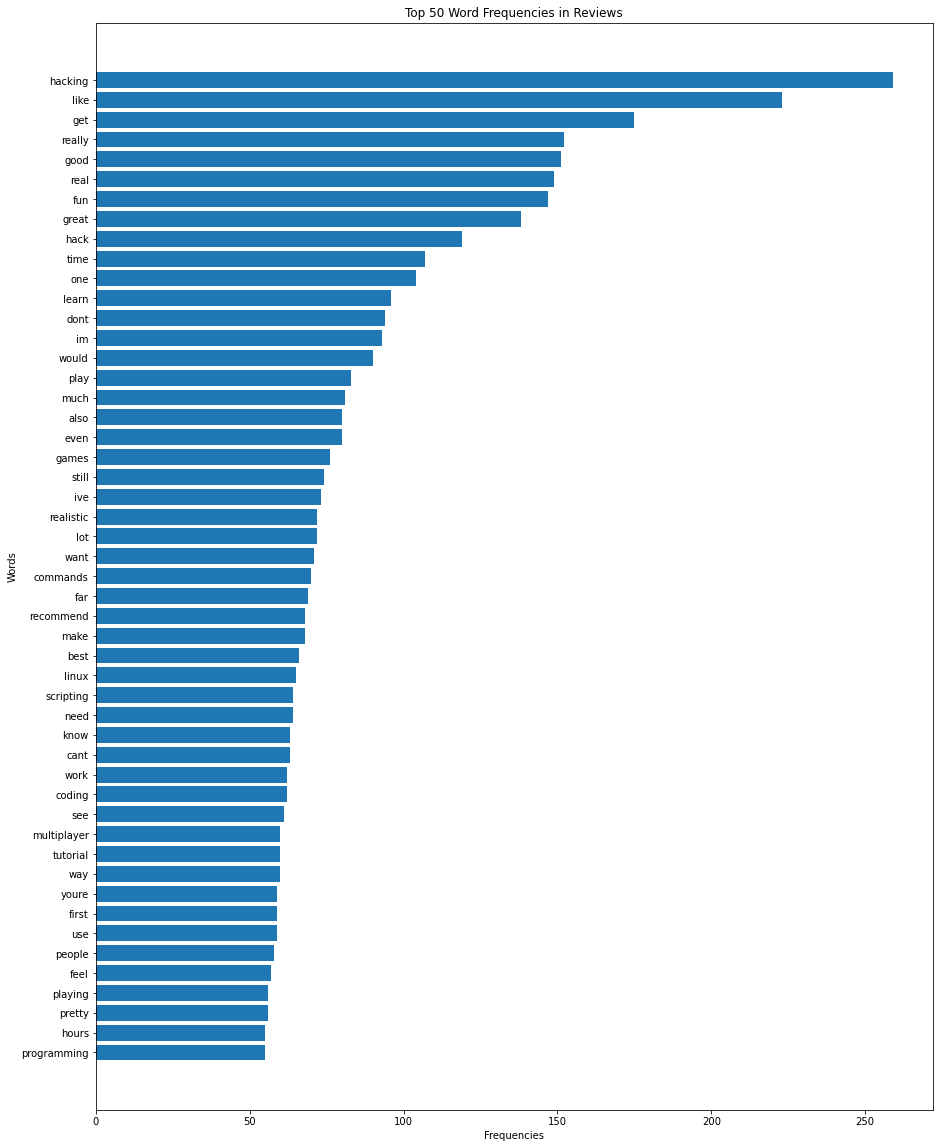

In [16]:
from collections import Counter

# Concatenating all reviews into a single string
all_reviews = ' '.join(reviews_df['cleaned_reviews_NS'])

# Creating a TextBlob object
blob = TextBlob(all_reviews)

# Counting word frequencies using Counter
word_counts = Counter(blob.words)

# Preparing data for plotting
words, counts = zip(*word_counts.most_common(50)) # Adjustable 

# Creating a bar plot for the word frequencies
plt.figure(figsize=(15, 20))
plt.barh(words, counts)
plt.xlabel('Frequencies')
plt.ylabel('Words')
plt.title('Top 50 Word Frequencies in Reviews')
plt.gca().invert_yaxis()  # To display the highest counts at the top
plt.show()

In [17]:
# Feature engineering retention score
reviews_df['retention_score'] = (
      (reviews_df['normalized_playtime_forever'] / reviews_df['normalized_playtime_forever'].max()) * 0.3 # positive indicator of user engagement with game throughout lifetime
    + (reviews_df['normalized_playtime_last_two_weeks'] / reviews_df['normalized_playtime_last_two_weeks'].max())* 0.4 # strong positive indicator of user engagement with game in recent weeks, showing strong indicator of retention
    +  reviews_df['voted_up'] * 0.15 # positive indicator of user likes the game
    +  reviews_df['steam_purchase'] * 0.05 # indicator of user more invested in the game compared to those who got it free
    + (reviews_df['textblob_sentiment'] * 0.05 / reviews_df['textblob_sentiment'].max()) # highly correlated with vader_sentiment, thus reduce the combined weight to 0.2
    + (reviews_df['vader_sentiment'] * 0.15 / reviews_df['vader_sentiment'].max()) # vader having more weight due to higher accuracy when it comes to negative sentiment compared to textblob
    - (reviews_df['days_from_last_played_time'] / reviews_df['days_from_last_played_time'].max()) * 0.1 # negative indicator of user not engaing with the game in recent period
    
)

# Rescaling the retention score from 0 to 1 
# Current retention score can be lower than 0 and higher than 1, although all features used to proxy this are normalized and weights add up to 1
scaler = MinMaxScaler()
reviews_df['retention_score_scaled'] = scaler.fit_transform(reviews_df[['retention_score']])

,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,playtime_category,reviewer_experience,vader_sentiment,cleaned_review_tokens,review_tokens_no_stopwords,cleaned_reviews_NS,retention_score,retention_score_scaled
0,english,This game is very realistic and is super fun! ...,2023-12-25 21:54:14,2023-12-25 21:54:14,1,1,0,0,0,1,0,True,177,84,514,514,167,2023-12-26 04:21:23,0.137000,6.244167,5.123964,6.244167,-0.613314,-0.834628,3.950013,0.324903,17,80,16,1,High,Veteran,0.8830,"[this, game, is, very, realistic, and, is, sup...","[realistic, super, fun, highly, recommend, giv...",realistic super fun highly recommend give go,0.534623,0.667210
1,english,I've been having too much fun playing it. Keep...,2023-12-25 21:15:47,2023-12-25 21:15:47,1,1,0,0,0,1,0,True,94,5,154,154,154,2023-12-25 21:12:38,0.500000,5.043425,5.043425,5.043425,-1.279696,-0.884405,3.138292,1.000000,17,63,13,1,Medium,Newbie,0.7906,"[ive, been, having, too, much, fun, playing, i...","[ive, much, fun, playing, keep, good, work]",ive much fun playing keep good work,0.431025,0.593137
3,english,"A good, and I mean good, hacking simulator for...",2023-12-25 18:32:14,2023-12-25 18:32:14,1,3,0,0.54356849193572998,0,1,0,True,200,11,21,21,17,2023-12-25 18:38:27,0.259430,3.091042,2.890372,3.091042,-2.363219,-2.215108,1.818448,0.809524,17,892,157,3,Low,Experienced,0.7269,"[a, good, and, i, mean, good, hacking, simulat...","[good, mean, good, hacking, simulator, underst...",good mean good hacking simulator understanding...,0.234024,0.452282
4,english,This is an amazingly realistic hacking simulat...,2023-12-25 18:26:44,2023-12-25 18:26:44,1,3,0,0.54356849193572998,0,1,0,True,0,21,46,46,35,2023-12-25 18:35:25,0.405167,3.850148,3.583519,3.850148,-1.941935,-1.786706,2.331616,0.760870,17,419,71,3,Low,Veteran,0.9191,"[this, is, an, amazingly, realistic, hacking, ...","[amazingly, realistic, hacking, simulator, sim...",amazingly realistic hacking simulator simulate...,0.338357,0.526880
6,english,As a security specialist of 20+ years you're d...,2023-12-25 18:21:49,2023-12-25 18:21:49,1,33,0,0.808946132659912109,0,1,0,True,373,30,410,410,181,2023-12-26 04:01:54,0.650000,6.018593,5.204007,6.018593,-0.738502,-0.785157,3.797521,0.441463,17,181,34,33,Medium,Veteran,0.8853,"[as, a, security, specialist, of, years, youre...","[security, specialist, years, youre, awesome, ...",security specialist years youre awesome job sh...,0.540351,0.671305


In [19]:
# Dropping columns that will not be used for model
reviews_df.drop(columns=['timestamp_created', 'timestamp_updated', 'author_num_games_owned', 'author_num_reviews', 'written_during_early_access', 'language'], inplace=True)

In [ ]:
# Previewing the dataset after feature engineering
reviews_df.head()

In [20]:
reviews_df.describe()

,voted_up,votes_up,votes_funny,comment_count,steam_purchase,received_for_free,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,textblob_sentiment,log_playtime_forever,log_playtime_at_review,log_playtime_last_two_weeks,normalized_playtime_forever,normalized_playtime_at_review,normalized_playtime_last_two_weeks,playtime_ratio,days_from_last_played_time,review_length,review_word_count,engagement_score,vader_sentiment,retention_score,retention_score_scaled
count,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,6.080000e+02,6.080000e+02,6.080000e+02,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000
mean,0.870066,3.907895,0.972039,0.174342,0.993421,0.011513,11292.970395,79.141447,3230.493421,0.136825,7.349287,6.474377,0.401097,3.177283e-16,1.329346e-16,1.316564e-16,0.569163,544.935855,356.072368,64.644737,5.054276,0.542461,0.243874,0.459325
std,0.336508,10.962332,6.349321,0.970334,0.080910,0.106768,50334.262825,821.634408,11797.334041,0.265882,1.803367,1.619314,1.480471,1.000823e+00,1.000823e+00,1.000823e+00,0.329451,569.918302,600.657310,107.377847,15.010551,0.462317,0.188835,0.135017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,7.000000,-0.750000,2.708050,2.079442,0.000000,-2.575770e+00,-2.716307e+00,-2.711480e-01,0.001903,17.000000,2.000000,1.000000,0.000000,-0.989800,-0.398539,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,478.500000,0.000000,214.500000,-0.002154,6.172742,5.372953,0.000000,-6.529529e-01,-6.807396e-01,-2.711480e-01,0.261019,90.750000,50.000000,9.750000,0.000000,0.380350,0.158577,0.398337
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1397.500000,0.000000,575.000000,0.119375,7.243141,6.356084,0.000000,-5.890843e-02,-7.311182e-02,-2.711480e-01,0.583587,291.000000,156.500000,29.000000,1.000000,0.700000,0.255570,0.467687
75%,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,4876.250000,0.000000,1724.250000,0.250000,8.492335,7.453127,0.000000,6.343629e-01,6.049203e-01,-2.711480e-01,0.898251,852.750000,429.000000,81.000000,4.000000,0.891925,0.340823,0.528643
max,1.000000,137.000000,115.000000,16.000000,1.000000,1.000000,878520.000000,18258.000000,152406.000000,1.000000,13.685995,11.934310,9.812413,3.516714e+00,3.374533e+00,6.362207e+00,1.000000,2219.000000,7993.000000,1460.000000,204.000000,0.999500,1.000064,1.000000


In [21]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608 entries, 0 to 730
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   review                              608 non-null    object        
 1   voted_up                            608 non-null    int64         
 2   votes_up                            608 non-null    int64         
 3   votes_funny                         608 non-null    int64         
 4   weighted_vote_score                 608 non-null    object        
 5   comment_count                       608 non-null    int64         
 6   steam_purchase                      608 non-null    int64         
 7   received_for_free                   608 non-null    int64         
 8   author_playtime_forever             608 non-null    int64         
 9   author_playtime_last_two_weeks      608 non-null    int64         
 10  author_playtime_at_review 

In [22]:
# Cleaned dataset JSON file name
cleaned_filename = 'reviews_cleaned.json'

# Saving the DataFrame to a JSON file
reviews_df.to_json(cleaned_filename, orient='records', lines=True)

print(f"DataFrame saved to {cleaned_filename}")

DataFrame saved to reviews_cleaned.json
